<mark><font size=3>**Suman Pan** - 218352</mark>
    
<mark><font size=3>**Clara Llòria** - 218147</mark>


# Lab 3: Camera calibration using a planar pattern


## 1. Introduction

In this assignment we are going to find the camera calibration parameters using a planar pattern.  The method consists of taking several images of a known planar pattern in different positions.  By detecting the pattern in the images, we will be able to recover the camera internal parameters as well as its pose relative to the pattern.  This will enable us to draw the cameras in 3D and to project 3D objects onto the images as in Augmented Reality applications.

### 1.1 The pattern
The planar pattern can be any flat image, usually a chessboard.  For simplicity, instead of the chessboard, we are going to use a flat screen to display a texture-rich image.  The ORB/SIFT/SURF descriptor will be used to compute correspondences between the picture of the screen with the picture stored in the computer, as it has been done in previous assignments for computing homographies.

### 1.2 Taking the images
You will use the provided images in a first stage.  Later on, you are asked to take pictures of a flat pattern with any other camera you want to calibrate.

### 1.3 Goals and Requirements

The goal of the current lab assignment is to learn the following concepts:

- How to compute the internal camera parameters from a set of plane homographies.  We will use the Image of the Absolute Conic for this. 

- How to compute the camera position with respect to the calibration target.

- How to add simple virtual 3D objects on the images of the calibration target.


We will assume that we already know the following concepts:

- What is a homography, how to match ORB/SIFT/SURF keypoints between images and how to robustly compute a homography from point correspondences.

- What is the camera projection matrix and what are the internal and external camera parameters and their matrix form $P = K(R|t)$.

- You have an idea of what is the Image of the Absolute Conic and you know that its matrix is simply $w = (K K ^T)^{-1} = K^{-T} K^{-1}$.

In [1]:
import numpy as np
import cv2
import random
import math
import sys
import matplotlib
from matplotlib import pyplot as plt
from operator import itemgetter
from utils import Ransac_DLT_homography, plot_camera, plot_image_origin
import plotly.graph_objects as go

C:\Users\pansu\anaconda3\lib\site-packages\numpy
C:\Users\pansu\anaconda3\lib\site-packages\cv2\data
C:\Users\pansu\OneDrive\Documentos\3_trim_4rto\Vision_3D\3D_Vision_labs\lab3
C:\Users\pansu\.matplotlib
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\.matplotlib
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pan

In [2]:
# !pip install plotly
# !pip install cufflinks

## 2. Calibration with a planar pattern

### 2.1 Load the images and compute homographies

As in the previous session, we are going to compute homographies between images using ORB/SIFT/SURF matching and RANSAC. 

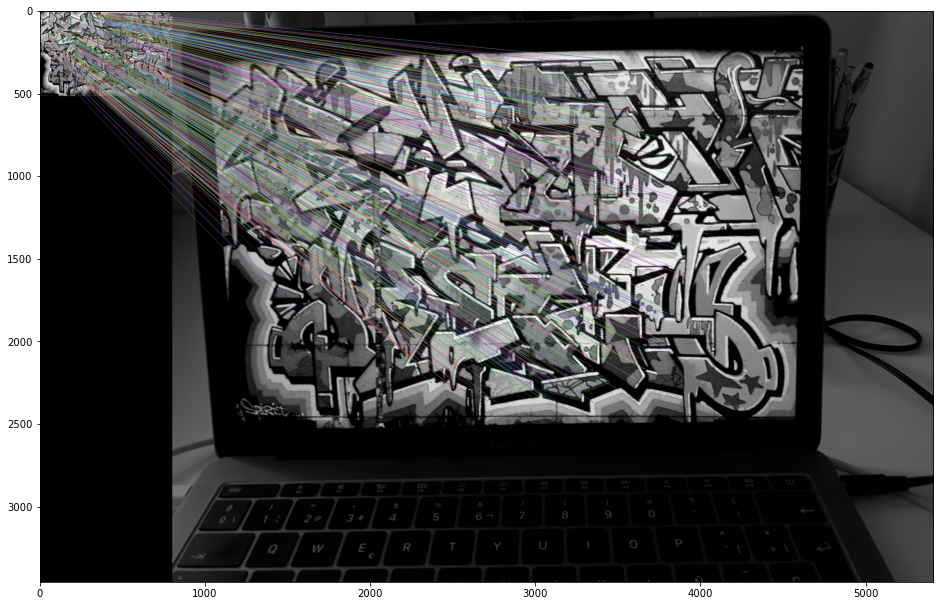

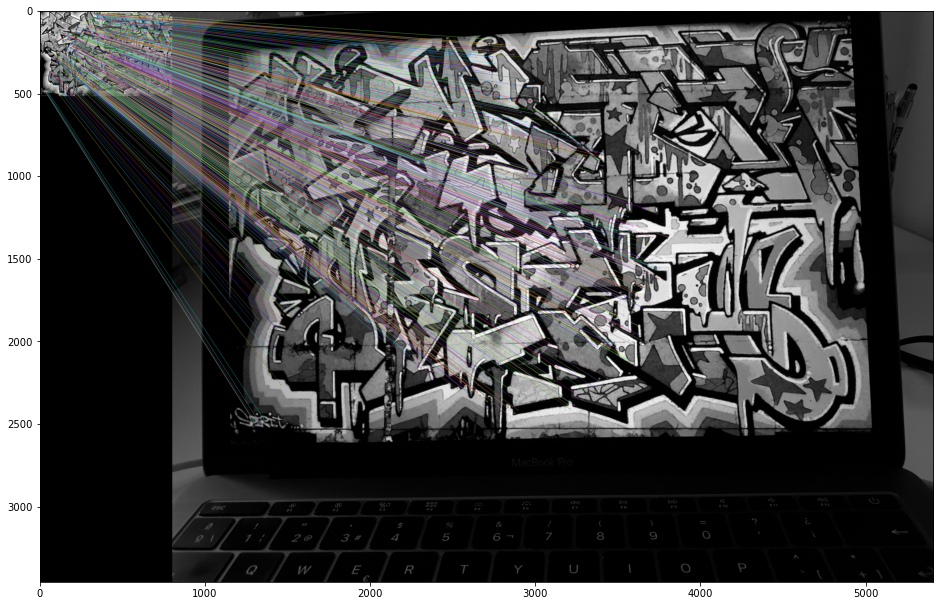

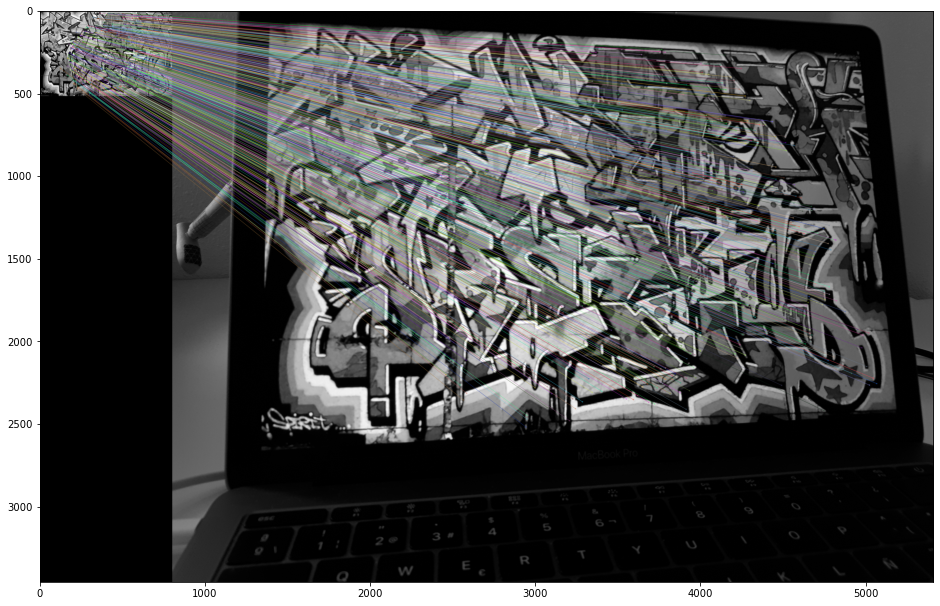

In [2]:
template = cv2.imread('Data/template.jpg',cv2.IMREAD_GRAYSCALE)
images = []
N = 3 # 5
for i in range(1,N+1):
    m = cv2.imread("Data/calib{0}.jpg".format(i),cv2.IMREAD_GRAYSCALE)
    images.append(m)
    
# Initiate SIFT detector
sift = cv2.SIFT_create(4000)

# find the keypoints and descriptors
kpt, dest = sift.detectAndCompute(template,None)
kpi, desi = [], []
for m in images:
    kp, des = sift.detectAndCompute(m,None)
    kpi.append(kp)
    desi.append(des)


# Keypoint matching and homography estimation
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
H = []
for i in range(N):
    matches = bf.match(dest,desi[i])
    
    # Fit homography and remove outliers
    points1 = []
    points2 = []
    for m in matches:
        points1.append([kpt[m.queryIdx].pt[0], kpt[m.queryIdx].pt[1], 1])
        points2.append([kpi[i][m.trainIdx].pt[0], kpi[i][m.trainIdx].pt[1], 1])
        
    points1 = np.asarray(points1)
    points1 = points1.T
    points2 = np.asarray(points2)
    points2 = points2.T
    
    Hi, indices_inlier_matches = Ransac_DLT_homography(points1, points2, 3, 1000)
    H.append(Hi)
    
    # Show inlier matches
    inlier_matches = itemgetter(*indices_inlier_matches)(matches)
    img_12 = cv2.drawMatches(template,kpt,images[i],kpi[i],inlier_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_12)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()

In [4]:
H[0]


array([[ 4.32747604e+00,  4.61830338e-01,  1.90401389e+02],
       [-6.69883384e-02,  4.55133015e+00,  2.76021420e+02],
       [ 8.51036270e-06,  1.58664734e-04,  9.53265307e-01]])

### 2.2 Compute the Image of the Absolute Conic

Given the homographies we are now going to compute the Image of the Absolute conic (IAC).  Read carefully the theory in the provided file 'calibration.pdf'.

**Q1.** Complete the code below to compute the IAC from the homographies.

**Q2.** How many images are required to compute the IAC? What would you do if you had fewer images?

<mark><font size=3>**Answer:**</mark>

Since there are 5 unknowns to compute $\omega$ we need at least 3 images since from each of them we get 2 equations.
    
If we had fewer images we would need to add some constraints such as 0 skew, aspect ration 1 or known principal point.

In [39]:
# Compute the Image of the Absolute Conic
A = np.zeros((2*N, 6))

for i in range(N):
    h = H[i]
    A[2*i-1, :] = np.array([h[0,0]*h[0,1], h[0,0]*h[1,1] + h[1,0]*h[0,1], h[0,0]*h[2,1] + h[2,0]*h[0,1], h[1,0]*h[1,1], h[1,0]*h[2,1] + h[2,0]*h[1,1], h[2,0]*h[2,1] ])
    A[2*i, :] = np.array([h[0,0]**2, 2*h[0,0]*h[1,0], 2*h[0,0]*h[2,0], h[1,0]**2, 2*h[1,0]*h[2,0], h[2,0]**2])
    A[2*i, :] -= np.array([h[0,1]**2, 2*h[0,1]*h[1,1] , 2*h[0,1]*h[2,1], h[1,1]**2, 2*h[1,1]*h[2,1], h[2,1]**2])

u,s,vt = np.linalg.svd(A);
# print(u.shape)
# print(s.shape)

# linalg gives the v matrix transposed
# we need to transpose it again to obtian x in the last column
v = np.transpose(vt)
#     print(A)
x = v[5,:]# last colum of the v

w = np.zeros([3,3])
w[0,:] = np.asarray([x[0],x[1],x[2]])
w[1,:] = np.asarray([x[1],x[3],x[4]])
w[2,:] = np.asarray([x[2],x[4],x[5]])

# normalize by dividing all components by the last one
w /= w[2,2]

print(w)

[[ 5.22728430e-11 -2.55159324e-10 -6.32044381e-09]
 [-2.55159324e-10  1.92545017e-06 -1.25604318e-04]
 [-6.32044381e-09 -1.25604318e-04  1.00000000e+00]]


### 2.3 Compute the camera calibration matrix from the IAC

The IAC relates to the camera calibration matrix, $K$ as $\omega = K^{-T} K^{-1}$. Knowing $\omega$ we can get $K$ using the Cholesky factorization.

**Q3.** Write the code to compute the camera calibration from the IAC.

Fisrtly, we have the problem statement $\omega = K^{-T} K^{-1}$, and we want to find K, from w, applying the Cholesky factorization. Then, knowing the following properties:
1. Cholesky decomposition of a positive-definite matrix A is a decomposition of the form $A = LL^\top$, where L is a lower triangular matrix with real and positive diagonal entries, and LT denotes the conjugate transpose of L, namely the upper traingular matrix :
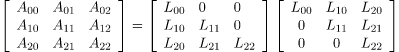
2. The K is matrix of form 
\begin{bmatrix}
\alpha_x & s & x_0\\ 
0 &  \alpha_y& y_0\\ 
 0&  0& 1
\end{bmatrix} Which is the upper traingular matrix of the Cholesky and is the matrix K we are looking for.

3. 
We can find then $K$ as :
\begin{equation}
\omega^\top=(K^{-T} K^{-1})^{-1} = (K^{-1})^{-1}(K^{-T})^{-1}=KK^{T}
\end{equation}
Applying the rule when we transpose or inverse for a group of matrices, is equal to reverse their order.
$(AB)^{-1}=B^{-1}A^{-1}$ and the inverse of a inverse matrix is itself $(A^{-1})^{-1}=A$

In [41]:
# our solution then is the inverse of w matrix, and apply the cholesky using the transpose of L.
w_inv = np.linalg.inv(w)
L = np.linalg.cholesky(w_inv)
K = L.T
print(K)

[[1.38358123e+05 1.85441123e+01 3.20370532e-03]
 [0.00000000e+00 7.23636415e+02 9.08918585e-02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [6]:
# complete ... 
# choleski factorization
# QR factorization
Q, R = np.linalg.qr(w)

K = np.linalg.inv(R)
# w = (RQ)*(RQ)^T

# ch_k = np.linalg.cholesky(w)


# K = np.linalg.inv((w*np.transpose(w)))
# print(K)

**Q4.** What result do you get? Can you interpret the values of $K$ in geometric terms? Which ones are related to the image size? How are they related? Do they make sense in your results?

In [42]:
print("Value of K: \n",K)
imgHeight,imgWidth = np.shape(images[0])
print("Value of img Width and Height: \n", imgWidth,"x", imgHeight, "pixels")
# divide width of an image or screen, divided by the height. 
aspect_ratio = imgWidth / imgHeight
print("Aspect ratio: ",aspect_ratio, ", 4:3")

Value of K: 
 [[1.38358123e+05 1.85441123e+01 3.20370532e-03]
 [0.00000000e+00 7.23636415e+02 9.08918585e-02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Value of img Width and Height: 
 4608 x 3456 pixels
Aspect ratio:  1.3333333333333333 , 4:3


In [22]:
3456/ 4608

0.75

<mark><font size=3>**Answer:**</mark> 
    
The camera calibration estimates the parameters of a pinhole camera model, which are represented in a 3x4 matrix knowed as **camera matrix** or **projection matrix**. Using these parametrers we can estimate either the size of an object or determine the location of the camera in the world coordinate.

---
    
In this first instance, we obtain the $K$ as calibration matrix or internal matrix, which has the general form
of:
\begin{bmatrix} 
\alpha_x & s & x_0\\ 
0 &  \alpha_y& y_0\\ 
 0&  0& 1
\end{bmatrix}

With this matrix we can obtain the following information :
1. Camera center (in pixels), the center coordinate of the pinhole, denoted as ($x_0$,$y_0$).
2. "Focal length" or focal distance (in pixels), is the distance between the pinhple and the image plane. This variable affects the size of the projected image and how the camera are focus on the object using lenses.
Which are denoted as ($\alpha_x,\alpha_y$) or ($f_x,f_y$)
3. Skew factor, θ = arctan(1/s), which often is 0, but if it is non-zero the images axes are not perpendicular. We can use $s$ to calculate the angle that the image are affine transformed.

The ones that are related to the image size, are the ($\alpha_x,\alpha_y$), since we have the following relation:
- $picture_{height} = \alpha_yY_{inPattern}$
- $picture_{width} = \alpha_xX_{inPattern}$

This is from similar triangles, given 3D point (X,Y,Z), anf 2D point (x,y):
    
$x=f_x(X/Z)$ ; $y=f_y(Y/Z)$. 
Since in this case, we assume Z=0, because the woord. ref. attach with the pattern plane. Therefore:
- $Y_{inPattern} = picture_{height} / \alpha_y$
- $X_{inPattern} = picture_{width}/ \alpha_x$

    
    
realitat el que tens no es la focal length en la matriu k sino que el que anomenes fx es en realitat m_x * f i el mateix amb fy=m_y 
!!tens l'aspect ratio de la càmera que determina la dimensionalitat de la imatge per això tens en realitat dos field of views. ??
    

    


In [38]:
K[0,0]

138358.12207663964

In [43]:
# Y = y/fy
Y= imgHeight/K[1,1];  # is the size of the image Y.
X= imgWidth/K[0,0]
print("img size Y,X:",Y,X) ###??

img size Y,X: 4.775879061047442 0.033304875150509616


**Q5.** Compute the field of view angle of the camera.

In [7]:
# skiew factor???


fov_x = 2*np.arctan(imgWidth/2*K[0,0])  # corregir
fov_y = 2*np.arctan(imgHeight/2*K[1,1])

print(fov_x)
print(fov_y)

3.141592653582929
3.1415926463951678


### 2.4 Compute camera position and orientation

Given the computed calibration $K$ and the homografies $H$, we can compute the 3D position and orientation of the camera with respect to the planar pattern.

**Q6.** Complete the code to compute the rotation and translation of each camera.

In [44]:
# Compute camera position and orientation
import math
R = []
t = []
P = []

K_inv = np.linalg.inv(K)
for i in range(N):
    # compute r1, r2, and t{i}
    h = H[i]
    Kinvh1 = np.dot(K_inv, h[:,0])
    Kinvh2 = np.dot(K_inv, h[:,1])
    Kinvh3 = np.dot(K_inv, h[:,2])
    r1 = Kinvh1/np.linalg.norm(Kinvh1)
    r2 = Kinvh2/np.linalg.norm(Kinvh2)
    ti = Kinvh3/np.linalg.norm(Kinvh1)
    
    # Solve the scale ambiguity by forcing r1 and r2 to be unit vectors.
    s = math.sqrt(np.linalg.norm(r1) * np.linalg.norm(r2)) * np.sign(ti[2])
    r1 = r1 / s
    r2 = r2 / s
    ti = ti / s
    t.append(ti)
    Ri = np.array([r1, r2, np.cross(r1,r2)])
    Ri = Ri.T
    
    # Ensure R is a rotation matrix
    #[U S V] = svd(R{i});
    U, d, Vt = np.linalg.svd(Ri)
    Ri = U @ np.identity(3) @ Vt
    R.append(Ri)
   
    # Pi = K * [Ri ti]
    A = np.zeros((3,4))
    A[:3,:3] = Ri
    A[:,3] = ti
    Pi = K @ A
    P.append(Pi)

**Q7.** In which units are expressed the translation vector `ti`?

<mark><font size=3>**Answer:**</mark>

In pixels?since we are projecting to the image plane.

The following code allows to visualize in 3D the different cameras corresponding to the different images and the frame (rectangular boundaries) of the planar pattern. The cameras are illustrated with a pyramid that encodes the estimated position (apex) and orientation (base).

In [32]:
ny, nx = images[0].shape
ny,nx

(3456, 4608)

In [45]:
import plotly.graph_objects as go    

ny, nx = images[0].shape

fig = go.Figure()
for i in range(N):
    plot_camera(P[i], nx, ny, fig, "camera{0}".format(i))

plot_image_origin(nx/2, ny/2, fig, "image")
fig.show()

C:\Users\pansu\.plotly
C:\Users\pansu\.plotly
C:\Users\pansu\.plotly


**Q8.** Complete the code below to plot a moving planar target in front of a static camera.

**Q9.** When taking the images, we did move the camera and the planar pattern was static. The last plot shows a moving pattern in front of a static camera.  What is the relation between the two situations?

In [10]:
def plot_image_Rt(R,t,w, h, fig, legend):
    
    p1 = # to complete ...
    p2 = # to complete ...
    p3 = # to complete ...
    p4 = # to complete ...
    
    x = np.array([p1[0], p2[0], p3[0], p4[0], p1[0]])
    y = np.array([p1[1], p2[1], p3[1], p4[1], p1[1]])
    z = np.array([p1[2], p2[2], p3[2], p4[2], p1[2]])

    fig.add_trace(go.Scatter3d(x=x, y=z, z=-y, mode='lines',name=legend))
    
    return


fig = go.Figure()
A = np.zeros((3,4))
A[0,0]=A[1,1]=A[2,2]=1

plot_camera(K@A, nx, ny, fig, "camera")
for i in range(N):
    plot_image_Rt(R[i], t[i], nx/2, ny/2, fig, "image{0}".format(i))

fig.show()

SyntaxError: invalid syntax (<ipython-input-10-0b964e83478c>, line 3)

### 2.5 Augmented reality

We now have the projection matrices, $P$, of each image with respect to the planar target's reference frame. We can use these projection matrices for projecting 3D points onto the images. Given a 3D point, we can project it using the projection matrix and plot the projection over the image.

**Q10.** Complete the code below to plot a cube in front of the calibration pattern on each image. The result should look as if a cube was attached to the pattern as the pattern moves from image to image.

In [ ]:
Th, Tw = template.shape
cube_corners = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0], [0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1], [0, 0, 1], [0, 0, 0], [1, 0, 0], [1, 0, 1], [0, 0, 1], [0, 0, 0], [0, 1, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1], [0, 1, 0]])

import numpy.matlib
offset = np.array([Tw/2, Th/2, -Tw/8])
M = cube_corners.shape[0]
X = (cube_corners - 0.5) * Tw/ 4 + np.matlib.repmat(offset, M, 1)

X = X.T
ones = np.ones(M)
Xh = np.stack((X[0,:], X[1,:], X[2,:], ones), axis=0)

line_color = (0, 255, 0)

for i in range(N):
    
    xp = # complete ...
    
    image = cv2.imread("Data/calib{0}.jpg".format(i+1),cv2.IMREAD_COLOR) 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray = image
    image_gray[:, :, 0] = gray[:, :]
    image_gray[:, :, 1] = image_gray[:, :, 0]
    image_gray[:, :, 2] = image_gray[:, :, 0]
    for j in range(M-1):
        image = cv2.line(image_gray, (xp[0,j],xp[1,j]), (xp[0,j+1],xp[1,j+1]), line_color, 4) 
    plt.imshow(image)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()


**Q11.** Repeat all the process using your own images (you may use from 3 to 5 different views of a planar pattern). Comment the results and try to find an explanation in case it doesn't work.

### 2.6 Reducing the number of images

In case we have some knowledge about the camera parameters like the principal point, the aspect ratio or zero skew factor the number of images needed for calibration can be reduced.

**Q12.** Add a linear constraint to enforce skew 0.  See Zhang's paper (zhang98.pdf) [1]. What is the minimum number of views you need to calibrate the camera in this case?

**Q13.** Can you calibrate from a single image? How? Adapt your code to be able to calibrate from just a single image. Compare the results with the ones obtained when using more images. 

**Optional:** Using the last result you can create a video where the projected virtual cube automatically adapts to the changing point of view when you move the camera.

[1] Zhengyou Zhang. A flexible new technique for camera calibration, IEEE Transactions on pattern analysis and machine intelligence, 22(11), 1330-1334, 2000.